In [1]:
import sys
sys.path.insert(0, '../../_libs/')
import NEMO_tools as Nts

In [2]:
import glob
import datetime
import scipy.io
import scipy.signal
import numpy as np
import netCDF4 as nc
import cartopy.feature
import matplotlib.pyplot as plt
from NEMO_tools import reporj_NEMOgrid
from mpl_toolkits.basemap import Basemap, cm
% matplotlib inline

In [3]:
RB=[0.25, 0.41, 0.88]    # Royal blue
AM=[0.90, 0.17, 0.31]    # Amathran

In [4]:
def EOF(H, nmode=10, ndim=3, reverse=1):
    '''
    Converted from MATLAB to Python 2.7 code @ 2015/06/15 - YKS
     + ndim: [LAT, LON, TIME] data (=3) or [MAP, TIME] data (=2)
     + reverse: normalized spatial pattern (=0), normalized PC (=1)
    % ======================================================================= %
    % Input
    %   H: Variable required for EOF comutation, H(LAT, LON, Time) 
    %       or H(Space, Time) is accepted.
    %   nmode: Number of modes output
    % Output
    %   EOFs: EOF Spatial Pattern
    %   PC: Timeseries cooresponding to each EOFs
    %   expvar: Explained variance
    % ======================================================================= %
    % Author
    %   Yingkai Sha
    %       yingkaisha@gmail.com
    % 2014/3/18
    % ======================================================================= %
    '''
    ##import scipy.linalg.eig as eig
    # Get the size of array
    if ndim == 3:
        LAT, LON, T = H.shape
    elif ndim == 2:
        LON, T = H.shape
        LAT = 1
    # Covarience
    H = np.reshape(H, [LAT*LON, T]).T
    R=np.dot(H, H.T); N = np.size(R, 0)
    # Allocation
    PC     = np.zeros([nmode, T]);
    expvar = np.zeros([nmode]);
    eof    = np.zeros([N, LAT*LON]);
    EOFs   = np.zeros([LAT, LON, nmode]);
    # Eigvector analysis
    L, E = np.linalg.eig(R)
    # Get modes
    E    = np.dot(H.T, E)
    #sq   = (np.sqrt(np.diag(L))).T
    #sq   = sq[0, :]
    sq = np.sqrt(L)
    E    = E/sq
    Z    = np.dot(E.T, H.T)
    for i in range(nmode):
        eof[i, :] = np.squeeze(E[:, i]).T
        PC[i, :]  = np.squeeze(Z[i, :])
    # Get expvar
    L = np.abs(L)
    dsum = np.sum(np.abs(L))
    # Output
    for i in range(nmode):
        expvar[i] = L[i]/dsum
        EOFs[:, :, i] = np.reshape(eof[i, :], [LAT, LON])
    if reverse==1:
        EOFs, PC = reverse_std(EOFs, PC, nmode)
    return EOFs, PC, expvar

def reverse_std(EOFs, PC, nmode):
    for i in range(nmode):
        STD = np.nanstd(PC[i, :])
        PC[i, :] = PC[i, :]/STD
        EOFs[:, :, i] = EOFs[:, :, i]*STD
    return EOFs, PC

In [5]:
def seasonal_decomp3d(data, method=0):
    '''
    =======================================================================
    Remove the seasonal cycle from 1D data
                            ----- created on 2015/06/15, Yingkai (Kyle) Sha
    -----------------------------------------------------------------------
        data = seasonal_decomp(...)
    -----------------------------------------------------------------------
    Input:
            data: Time should be the first dim.
            method: removal done by anomaly (=0) or normalize (=1)
    ======================================================================= 
    '''
    data2 = np.empty(data.shape)
    for mon in range(12):
        temp_data = np.nanmean(data[mon:len(data):12, :, :], 0)
        if method == 0:
            data2[mon:len(data):12, :, :] = data[mon:len(data):12, :, :]-temp_data
    return data2

In [6]:
from dateutil.relativedelta import relativedelta
base = datetime.datetime(2002, 1, 1)
date_list = [base + relativedelta(months=x) for x in range(144)]

In [7]:
FName = '/ocean/yingkai/GEOTRACES/Simulations/BASE01_1m_20020101_20131231_ptrc_T.nc'
ptrc_obj = nc.Dataset(FName)
Ba = ptrc_obj.variables['Ba'][:, :20, :, :]
Ba[Ba==0]=np.nan
Ba = np.nanmean(Ba, 1)

/home/yingkai/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [8]:
Ba_np = Ba[:, 350:, :]
Ba_anom = seasonal_decomp3d(Ba_np)

In [9]:
coordinate_name=glob.glob('../../_data/Exchange/mesh_zgr.nc')
coordinate_obj=nc.Dataset(coordinate_name[0])
nav_lon=coordinate_obj.variables['nav_lon'][:]
nav_lat=coordinate_obj.variables['nav_lat'][:]

#nav_lon = nav_lon[350:, :]
#nav_lat = nav_lat[350:, :]

In [10]:
Ba_anom[np.isnan(Ba_anom)]=0.0

In [11]:
Ba_eof = np.transpose(Ba_anom, [1, 2, 0])

In [12]:
Ba_eof.shape

(450, 544, 144)

In [13]:
EOFs, PC, expvar = EOF(Ba_eof, nmode=10, ndim=3, reverse=1)

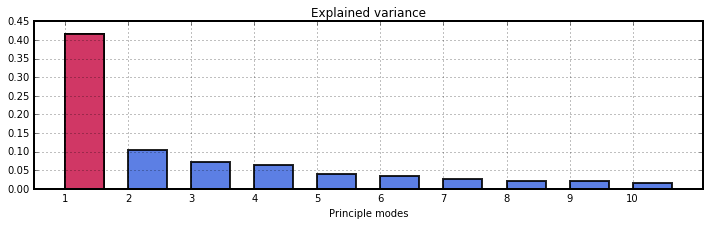

In [14]:
fig=plt.figure(figsize=(12, 3))
ax=plt.gca(); ax.grid(); ax.set_xlim(0.5, 11.118)
ax.bar(np.arange(1, 11), expvar, width=0.618, lw=2, alpha=0.85, color=RB)
ax.bar(1, expvar[0], width=0.618, lw=2, alpha=0.85, color=AM)
ax.set_xticks(np.arange(1, 11))
[i.set_linewidth(2) for i in ax.spines.itervalues()]
ax.set_xlabel('Principle modes')
ax.set_title('Explained variance', fontsize=12)

In [15]:
def draw_smode(lon, lat, EOFs, clevs, num, ax):
    proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=90, round=True, ax=ax)
    proj.drawparallels(np.arange(0, 90, 20), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
    proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0.5)
    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(lon, lat)
    CS = proj.contourf(x, y, EOFs[:, :, num], clevs, cmap=plt.cm.RdBu_r, extend='both')
    proj.contour(x, y, EOFs[:, :, num], clevs, colors='gray', linewidths=1.5)
    return CS

In [16]:
clevs = np.array([-5.5, -4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5])

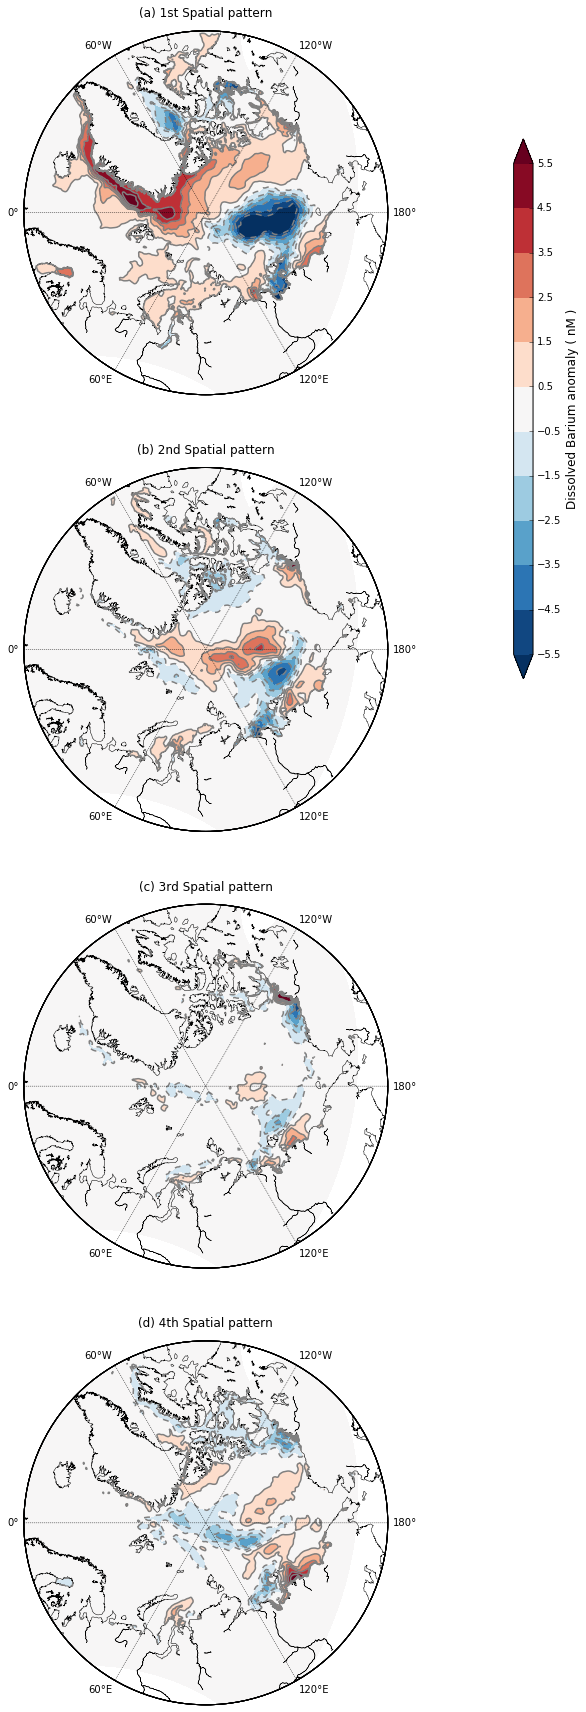

In [65]:
fig = plt.figure(figsize=(18, 30))
ax1 = plt.subplot2grid((4, 1), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((4, 1), (1, 0), colspan=1, rowspan=1)
ax3 = plt.subplot2grid((4, 1), (2, 0), colspan=1, rowspan=1)
ax4 = plt.subplot2grid((4, 1), (3, 0), colspan=1, rowspan=1)
#
CS = draw_smode(nav_lon[350:, :], nav_lat[350:, :], EOFs, clevs, 0, ax1)
ax1.set_title('(a) 1st Spatial pattern', y=1.025)
draw_smode(nav_lon[350:, :], nav_lat[350:, :], EOFs, clevs, 1, ax2)
ax2.set_title('(b) 2nd Spatial pattern', y=1.025)
draw_smode(nav_lon[350:, :], nav_lat[350:, :], EOFs, clevs, 2, ax3)
ax3.set_title('(c) 3rd Spatial pattern', y=1.025)
draw_smode(nav_lon[350:, :], nav_lat[350:, :], EOFs, clevs, 3, ax4)
ax4.set_title('(d) 4th Spatial pattern', y=1.025)
#colorbar
cax  = fig.add_axes([0.75, 0.6, 0.015, 0.25])
CBar = fig.colorbar(CS, cax=cax, orientation='vertical')
CBar.set_label('Dissolved Barium anomaly ( nM )', fontsize=12)
CBar.ax.tick_params(axis='x', length=12)
CBar.set_ticks(clevs)

http://onlinelibrary.wiley.com/doi/10.1029/2009JC005873/epdf

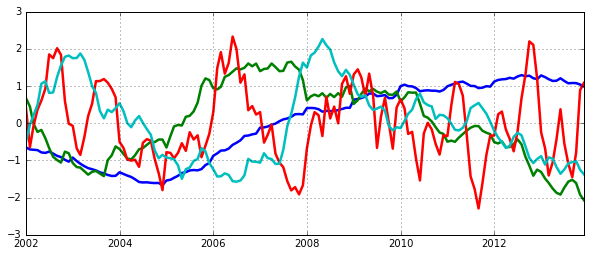

In [71]:
fig = plt.figure(figsize=(10, 4))
ax = fig.gca(); ax.grid()
ax.plot(date_list, PC[0:4, :].T, lw=2.5)

## Second mode: Intensity of transpolar drift

In [28]:
MAT = scipy.io.loadmat('../../_data/Mask files/velocity_driven_transport_mask.mat')
vdt_mask = MAT['mask_arctic'][:]
lon_mask = MAT['lon'][:]
lat_mask = MAT['lat'][:]

nav_lon=coordinate_obj.variables['nav_lon'][:]
nav_lat=coordinate_obj.variables['nav_lat'][:]

mask_interp = reporj_NEMOgrid(lon_mask, lat_mask, vdt_mask, nav_lon, nav_lat, method='nearest')
mask_range = reporj_NEMOgrid(lon_mask, lat_mask, vdt_mask, nav_lon, nav_lat, method='linear')
mask_interp[np.isnan(mask_range)] = np.nan
mask_plot = np.ma.masked_where(np.isnan(mask_interp), mask_interp)

In [29]:
MAT = scipy.io.loadmat('../../_data/Exchange/UV_current.mat')
vozocrtx0 = MAT['vozocrtx0'][:]
vozocrtx1 = MAT['vozocrtx1'][:]
vomecrty0 = MAT['vomecrty0'][:]
vomecrty1 = MAT['vomecrty1'][:]

In [30]:
#vdt_ns = vomecrty0[:, mask_interp==2]
#vdt_ns[vdt_ns>0] = np.nan
#vdt = np.abs(np.nanmean(vdt_ns, 1))

In [40]:
u_tpd = vozocrtx0[:, mask_interp==2]
v_tpd = vomecrty0[:, mask_interp==2]
vdt = np.abs(np.nanmean(np.sqrt(u_tpd*u_tpd+v_tpd*v_tpd), 1))

In [41]:
from scipy.stats.stats import pearsonr

**Transpolar drift intensity v.s. 2nd PC mode**

In [42]:
pearsonr(PC[1, :], vdt)

(0.56528496444381426, 1.5675573902017459e-13)

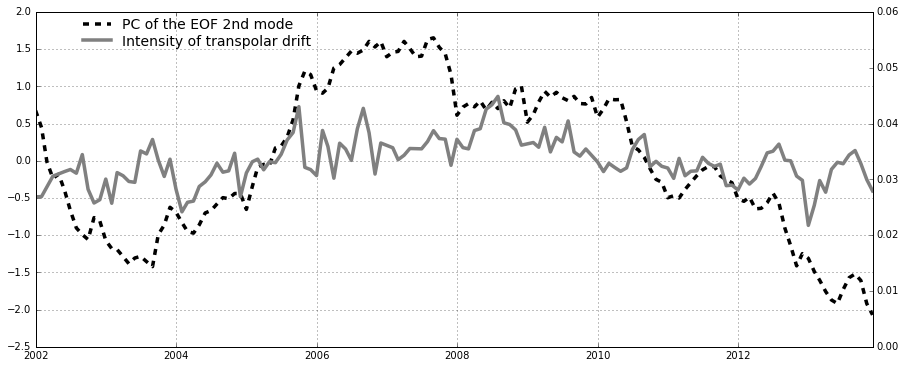

In [52]:
fig = plt.figure(figsize=(15, 6))
ax = fig.gca(); ax.grid()
ax2 = ax.twinx()

ax2.set_ylim([0, 0.06])

ax.plot(date_list, PC[1, :], 'k--', lw=3.5, label='PC of the EOF 2nd mode')
ax2.plot(date_list, vdt, 'gray', lw=3.5, label='Intensity of transpolar drift')

LG = ax.legend(numpoints=1, bbox_to_anchor=(0.05, 1.0), loc=2, borderaxespad=0., prop={'size':14}); LG.draw_frame(False)
LG = ax2.legend(numpoints=1, bbox_to_anchor=(0.05, 0.95), loc=2, borderaxespad=0., prop={'size':14}); LG.draw_frame(False)

In [54]:
H_FName = '/ocean/yingkai/GEOTRACES/FORCING/ANHA4/sossheig_monmean.nc'
h_obj = nc.Dataset(H_FName)
SSH = h_obj.variables['sossheig'][:, :, :]

SSH_BG = np.nanmax(SSH[:, mask_interp==1], 1) + 0.4

In [62]:
pearsonr(PC[0, :], SSH_BG[:])

(0.25541630963645318, 0.0020036018348496558)

In [60]:
pearsonr(PC[0, 72:], SSH_BG[72:])

(-0.46858918941084382, 3.3059330072548127e-05)

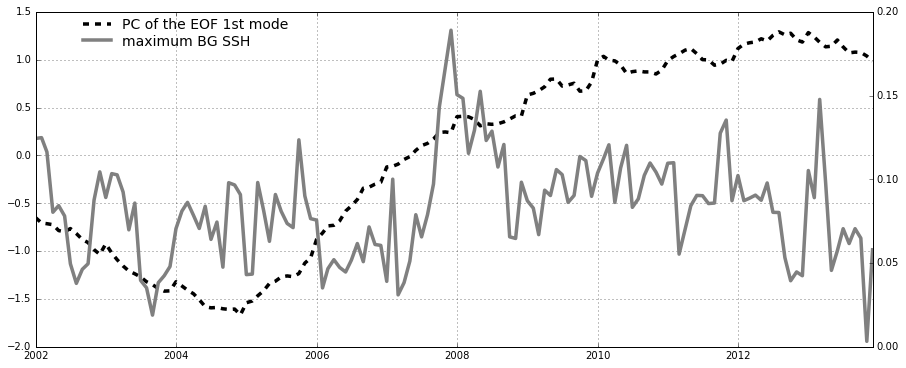

In [56]:
fig = plt.figure(figsize=(15, 6))
ax = fig.gca(); ax.grid()
ax2 = ax.twinx()

#ax2.set_ylim([0, 0.06])

ax.plot(date_list, PC[0, :], 'k--', lw=3.5, label='PC of the EOF 1st mode')
ax2.plot(date_list, SSH_BG, 'gray', lw=3.5, label='maximum BG SSH')

LG = ax.legend(numpoints=1, bbox_to_anchor=(0.05, 1.0), loc=2, borderaxespad=0., prop={'size':14}); LG.draw_frame(False)
LG = ax2.legend(numpoints=1, bbox_to_anchor=(0.05, 0.95), loc=2, borderaxespad=0., prop={'size':14}); LG.draw_frame(False)